In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [31]:
# Load preprocessed methylation data
# Assuming data contains columns: 'sample_id', 'region', 'methylation_level', 'condition'
df = pd.read_csv('/Users/katherine/Desktop/preprocessed_methylation_data.csv')

# Display the first few rows to ensure data is loaded correctly
print(df.head())

  Sample Tissue  Type       DR1        5P       MID        3P       ALU  \
0    NaN    NaN   NaN  0.438653  0.578036  0.615247  0.523142  0.531331   
1  18248  blood  CTRL  0.559828  0.656634  0.703551  0.592920  0.559637   
2  18304  blood  CTRL  0.584125  0.674996  0.699920  0.559170  0.577169   
3  18488  blood  CTRL  0.640974  0.731978  0.708021  0.602748  0.576509   
4  18521  blood  CTRL  0.608480  0.727214  0.707802  0.551197  0.566276   

       LINE       TAR  ...  normalized_5P  normalized_MID  normalized_3P  \
0  0.671477  0.459324  ...       0.000000        0.000000       0.000000   
1  0.747368  0.422131  ...       0.487603        0.615007       0.583513   
2  0.741759  0.386503  ...       0.601523        0.589720       0.301284   
3  0.761978  0.638462  ...       0.955028        0.646142       0.665696   
4  0.750467  0.477366  ...       0.925474        0.644612       0.234605   

   normalized_ALU  normalized_LINE  normalized_TAR  normalized_RS447  \
0        0.000000   

In [32]:
# Ensure 'normalized_' columns exist
methylation_columns = ['DR1', '5P', 'MID', '3P', 'ALU', 'LINE', 'TAR', 'RS447', '4qA', '4qA 1-14', '4qA 15-56']
normalized_columns = [f'normalized_{col}' for col in methylation_columns]

# Separate data for controls and FSHD1 patients
controls = df[df['Type'] == 'CTRL']
fshd_patients = df[df['Type'] == 'FSHD1']

In [33]:
# Function to identify DMRs
def identify_dmrs(controls, fshd_patients, alpha=0.05):
    results = []
    for col in normalized_columns:
        control_values = controls[col]
        fshd_values = fshd_patients[col]
        
        # Perform t-test
        t_stat, p_value = stats.ttest_ind(control_values, fshd_values)
        
        results.append({'region': col, 't_stat': t_stat, 'p_value': p_value})
    
    # Adjust p-values for multiple testing
    results_df = pd.DataFrame(results)
    results_df['adjusted_p_value'] = multipletests(results_df['p_value'], method='fdr_bh')[1]
    
    # Filter DMRs based on adjusted p-value
    dmrs = results_df[results_df['adjusted_p_value'] < alpha]
    return dmrs

In [34]:
# Identify DMRs
dmrs = identify_dmrs(controls, fshd_patients)
print(dmrs)

           region    t_stat   p_value  adjusted_p_value
0  normalized_DR1  3.404082  0.001495          0.016449


In [35]:
# Load regulatory region data
# Assuming the data contains columns: 'region', 'type' (e.g., promoter, enhancer), 'gene'
regulatory_regions = pd.read_csv('regulatory_regions.csv')

In [ ]:
# Merge DMRs with regulatory regions to focus on specific areas
dmrs_regulatory = pd.merge(dmrs, regulatory_regions, on='region')
print(dmrs_regulatory)

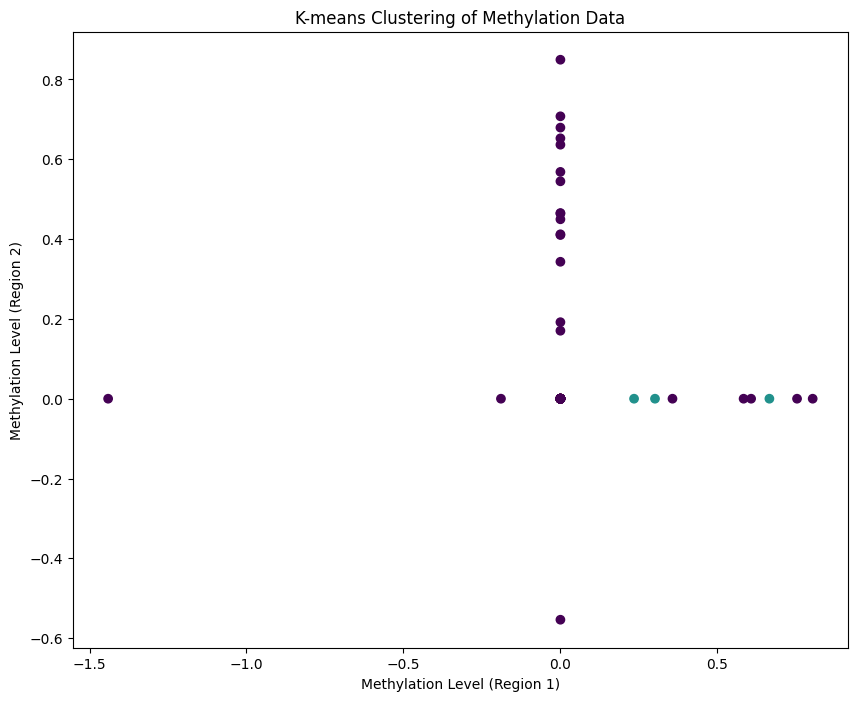

In [36]:
# Prepare data for clustering
# Pivot the data to create a matrix where rows are samples and columns are regions
methylation_matrix = df.pivot_table(index='Sample', columns='Type', values=normalized_columns).fillna(0)

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(methylation_matrix)
methylation_matrix['cluster'] = kmeans.labels_

# Plot clustering results
plt.figure(figsize=(10, 8))
plt.scatter(methylation_matrix.iloc[:, 0], methylation_matrix.iloc[:, 1], c=methylation_matrix['cluster'], cmap='viridis')
plt.xlabel('Methylation Level (Region 1)')
plt.ylabel('Methylation Level (Region 2)')
plt.title('K-means Clustering of Methylation Data')
plt.show()

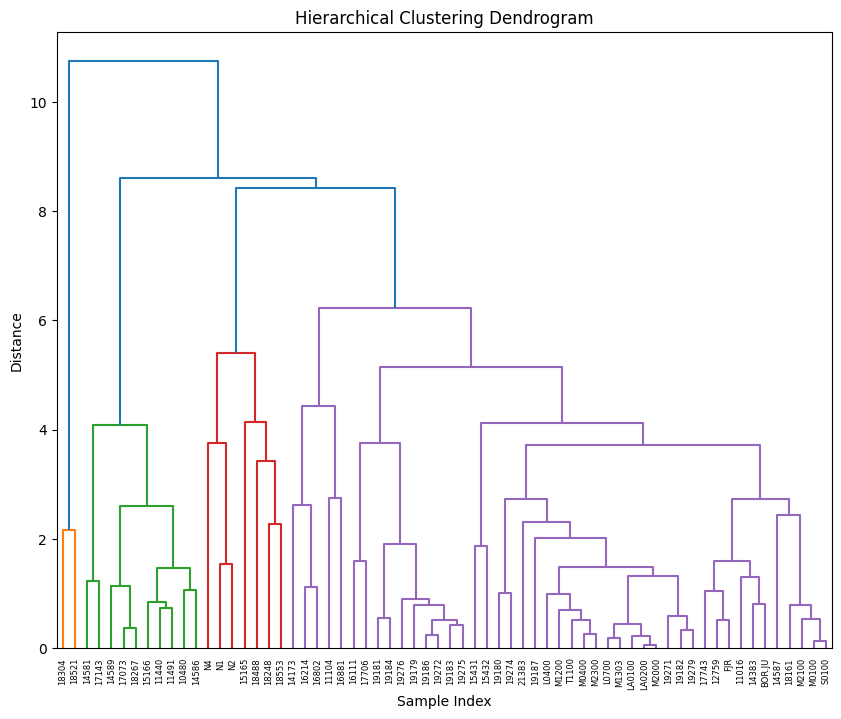

In [37]:
# Perform hierarchical clustering
linked = linkage(methylation_matrix.drop('cluster', axis=1), method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 8))
dendrogram(linked, labels=methylation_matrix.index)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [ ]:
# Load clinical severity data
# Assuming the data contains columns: 'sample_id', 'severity_score'
severity_data = pd.read_csv('severity_data.csv')



In [ ]:
# Merge methylation data with severity scores
merged_data = pd.merge(methylation_matrix, severity_data, on='sample_id')

In [ ]:
# Correlate methylation levels with severity scores
correlation_results = []
for region in methylation_matrix.columns[:-1]:  # Exclude 'cluster' column
    correlation = merged_data[region].corr(merged_data['severity_score'])
    correlation_results.append({'region': region, 'correlation': correlation})

In [ ]:
correlation_df = pd.DataFrame(correlation_results)
print(correlation_df)